<a href="https://colab.research.google.com/github/DutchVandaline/Analog_Clock/blob/main/Understanding_the_Essence_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding the Essenence CNN

In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import math
import numpy as np

## Normalization

pre_norm은 정규화 전 이미지를 보여주기 위한 작업. 256 * 256으로 바꾸고 텐서로 변환. post_norm은 정규화 이후의 모습을 보여주기 위한 작업. 평균과 표준편차를 이용해 정규분포(0-1)사이로 만들어 표준화하여 1.수치 안정성 확보 2. 빠른 수렴 3. 채널간 균형 유지 목적

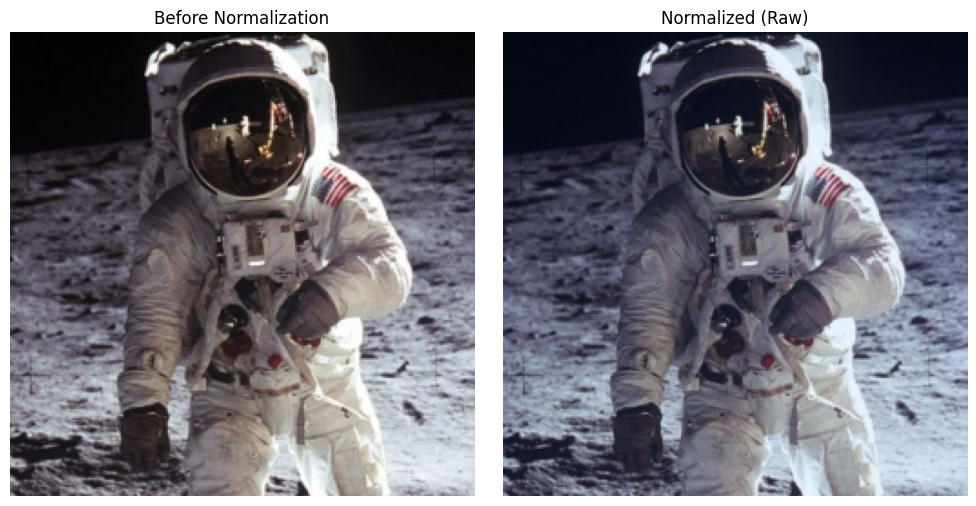

In [ ]:
img = Image.open('Aldrin_Apollo.jpeg').convert('RGB')

pre_norm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

post_norm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

tensor_pre  = pre_norm(img)
tensor_post = post_norm(img)

img_pre = tensor_pre.permute(1, 2, 0).numpy()
img_norm = tensor_post.permute(1, 2, 0).numpy()
min_val, max_val = img_norm.min(), img_norm.max()
img_norm_vis = (img_norm - min_val) / (max_val - min_val)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_pre)
axes[0].set_title('Before Normalization')
axes[0].axis('off')

axes[1].imshow(img_norm_vis)
axes[1].set_title('Normalized (Raw)')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)

    def forward(self, x):
        out1 = torch.relu(self.conv1(x))  # (1,16,256,256)
        p1   = self.pool(out1)            # (1,16,128,128)
        out2 = torch.relu(self.conv2(p1)) # (1,32,128,128)
        p2   = self.pool(out2)            # (1,32,64,64)
        out3 = torch.relu(self.conv3(p2)) # (1,64,64,64)
        p3   = self.pool(out3)            # (1,64,32,32)

        return [out1, p1, out2, p2, out3, p3]

시각화. 노란색이 필터가 집중한 부분, 파란색이 그렇지 않은 부분.

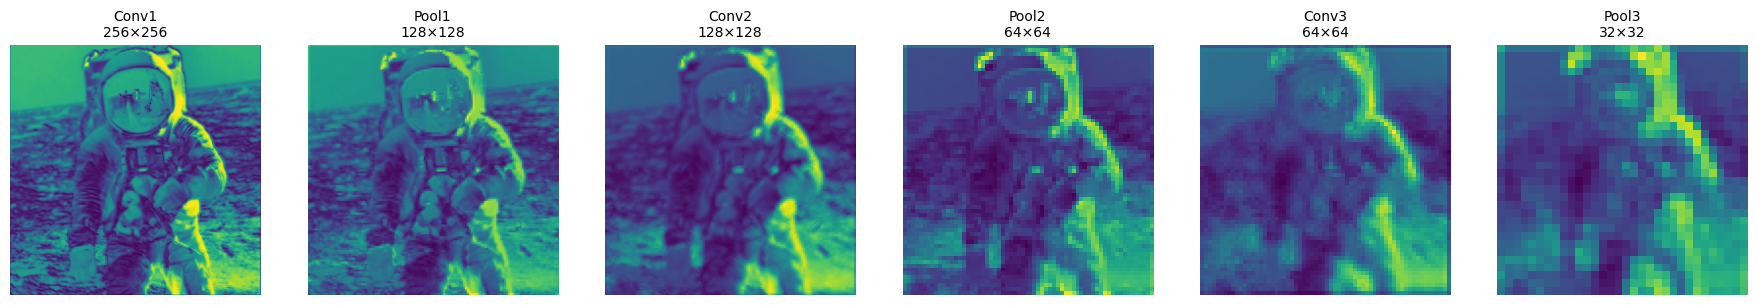

In [ ]:
input_tensor = post_norm(img).unsqueeze(0)
model = SimpleCNN()
features = model(input_tensor)

layer_names = ['Conv1', 'Pool1', 'Conv2', 'Pool2', 'Conv3', 'Pool3']
n_layers = len(features)

fig, axes = plt.subplots(1, n_layers, figsize=(n_layers * 3, 3))
for ax, fmap, name in zip(axes, features, layer_names):
    amap = fmap.squeeze(0).mean(dim=0).detach().cpu().numpy()
    ax.imshow(amap, cmap='viridis')
    ax.set_title(f'{name}\n{fmap.shape[2]}×{fmap.shape[3]}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

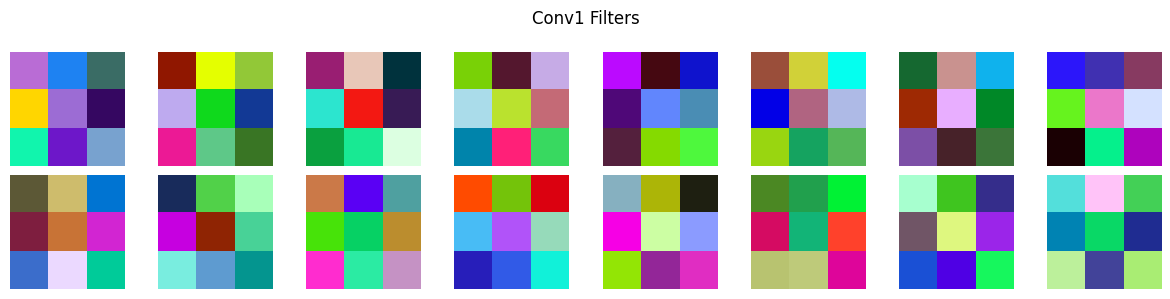

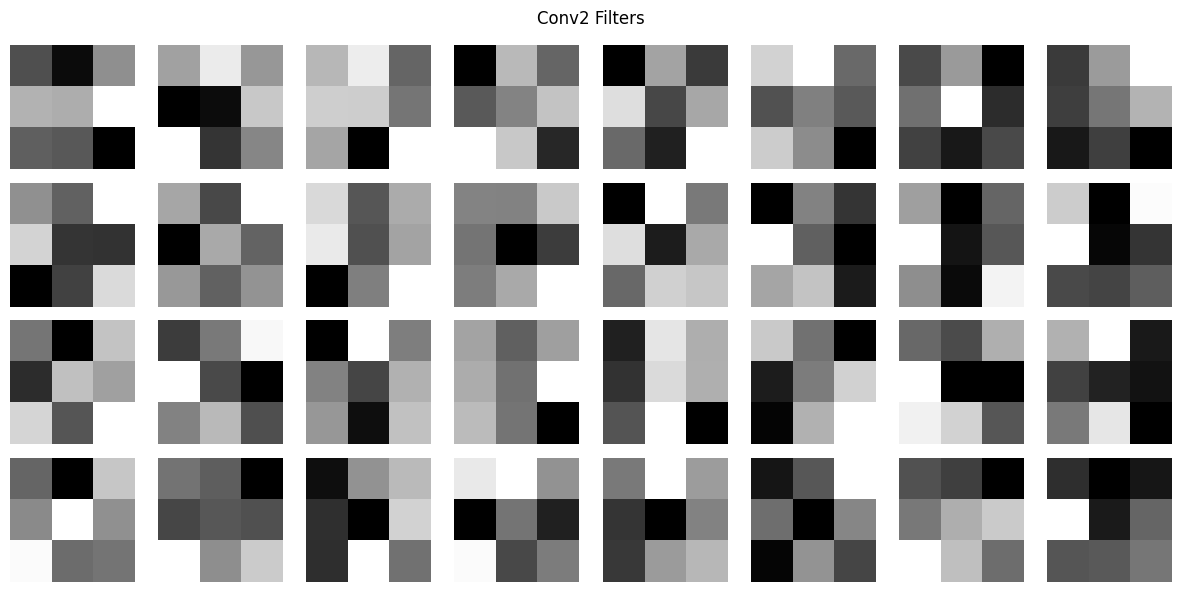

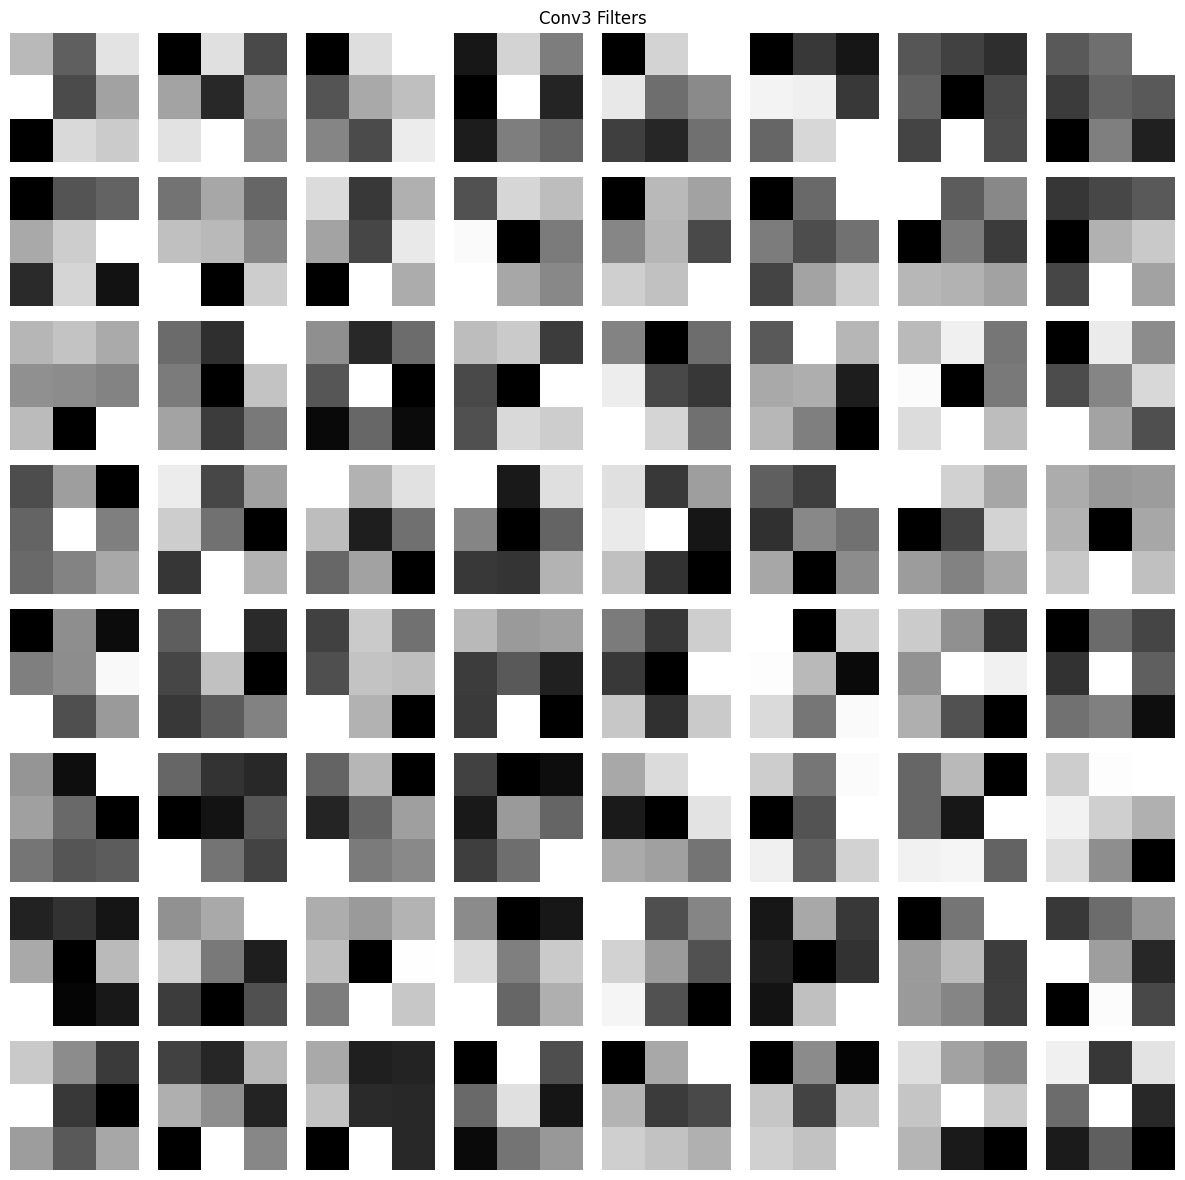

In [ ]:
def plot_filters(weights, title, n_cols=8):
    w = weights.cpu().detach()            # (out_c, in_c, k, k)
    out_c, in_c, k, _ = w.shape
    n_rows = math.ceil(out_c / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*1.5, n_rows*1.5))
    axes = axes.flatten()
    for i in range(out_c):
        kernel = w[i]  # (in_c, k, k)

        # ① 입력 채널이 3이면 RGB로, 아니면 채널 평균 그레이스케일로
        if in_c == 3:
            kern_vis = kernel.clone()
            kern_vis = (kern_vis - kern_vis.min()) / (kern_vis.max() - kern_vis.min())
            img_k = kern_vis.permute(1, 2, 0).numpy()
            axes[i].imshow(img_k)
        else:
            # 채널 평균 → (k,k)
            gray = kernel.mean(dim=0, keepdim=True)
            gray = (gray - gray.min()) / (gray.max() - gray.min())
            axes[i].imshow(gray.squeeze(0).numpy(), cmap='gray')

        axes[i].axis('off')

    # 빈 남은 서브플롯은 숨기기
    for j in range(out_c, len(axes)):
        axes[j].axis('off')

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_filters(model.conv1.weight, 'Conv1 Filters')
plot_filters(model.conv2.weight, 'Conv2 Filters')
plot_filters(model.conv3.weight, 'Conv3 Filters')



각 컨볼루션 레이어가 학습을 진행하며 집중하는 것을 표시. 층이 깊어질 수록 이미지의 크기가 작아지므로 흐릿하게 보임. 첫번째 층에서는 윤곽이 나타나고, 층이 깊어질 수록 세부에 집중.

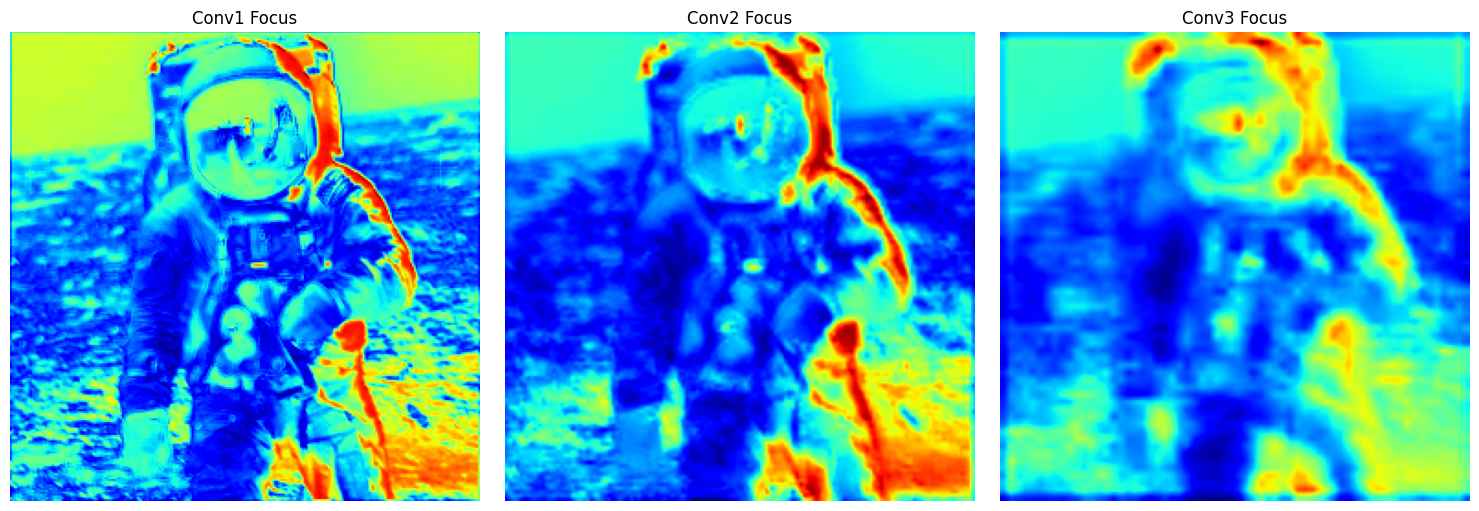

In [ ]:
model = SimpleCNN().eval()

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# 2) 이미지 로드
orig = Image.open('Aldrin_Apollo.jpeg').convert('RGB')
inp = transform(orig).unsqueeze(0)
orig_np = np.array(orig.resize((256,256)))  # (H,W,3)

# 3) 순전파 & 채널 평균 activation map
with torch.no_grad():
    feats = model(inp)
maps = []
for fmap in feats:
    amap = fmap.squeeze(0).mean(dim=0).cpu().numpy()  # (h,w)
    amap = (amap - amap.min()) / (amap.max() - amap.min())
    maps.append(amap)

# 4) upsample & overlay
titles = ['Conv1 Focus', 'Conv2 Focus', 'Conv3 Focus']
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for ax, amap, title in zip(axes, maps, titles):
    heat = cv2.resize(amap, (256,256))
    ax.imshow(orig_np)
    ax.imshow(heat, cmap='jet')
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()
plt.show()
